# TP #3 Order books analysis
## Numerical processing of financial data

MScT Data Science for business 

Enseignant: Anne-Claire Maurice

#### Objective
The goal of this hands-on session is to manipulate order books data and perfome some studies to compare different crypto exchanges.

#### Modules

NB: Feel free to add any other module you may need.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import json

## 1. Read and format the data

You have 4 files available:
- cbse_btc_usd_OB.json
- krkn_btc_usd_OB.json
- bfnx_btc_usd_OB.json
- stmp_btc_usd_OB.json

Each of them contains order books data observed on one exchange (Coinbase, Kraken, Bitfinex, or Bitstamp) between 01/04/2023 at 14:00 and 01/05/2023 at 14:00.

**Warning**: these files are too heavy to be opened in a standard text editor. If you want to look at the data structure, you can use the example file

### 1.1 Implement the method *read_file* to read an order book file and store the data in a DataFrame
The rows of the resulting DataFrame should be indexed by the field *timestamp* (of type datetime64[ns]) and there should be two columns: *asks* and *bids*.

Test this method on the example file: example_OB.json.

NB: each row of the resulting DataFrame represents a snapshot of an order book at a given timestamp. Cf slides to have an example of the resulting DataFrame you should obtain. 

In [2]:
def read_file(file_name:str, exchange_code:str):
    with open(file_name, "r") as f:
        data = json.load(f)
    try:
        exch_data = data[exchange_code]
    except:
        raise ValueError("No data found for the given exchange code.")
    df = pd.DataFrame.from_dict(exch_data)
    df.timestamp = pd.to_datetime(df.timestamp)
    df.set_index('timestamp', inplace = True)
    return df

In [3]:
file_test = "example_OB.json"
df = read_file(file_test, "bfnx")
df

,asks,bids
timestamp,,
2023-01-04 14:00:34.820999,"[{'amount': '0.02962417', 'price': '16835.0'},...","[{'amount': '12.73393924', 'price': '16834.0'}..."
2023-01-04 14:00:59.478000,"[{'amount': '0.01492413', 'price': '16835.0'},...","[{'amount': '13.86924219', 'price': '16834.0'}..."
2023-01-04 14:01:34.812999,"[{'amount': '0.01492413', 'price': '16835.0'},...","[{'amount': '5.46039684', 'price': '16834.0'},..."
2023-01-04 14:01:59.488000,"[{'amount': '1.10025924', 'price': '16833.0'},...","[{'amount': '2.88438048', 'price': '16832.0'},..."
2023-01-04 14:02:34.822000,"[{'amount': '1.35180348', 'price': '16833.0'},...","[{'amount': '1.66815826', 'price': '16832.0'},..."
2023-01-04 14:02:59.472000,"[{'amount': '0.25503149', 'price': '16833.0'},...","[{'amount': '4.24740291', 'price': '16832.0'},..."
2023-01-04 14:03:34.817999,"[{'amount': '0.91356027', 'price': '16833.0'},...","[{'amount': '2.04102229', 'price': '16832.0'},..."
2023-01-04 14:03:59.480000,"[{'amount': '0.91356027', 'price': '16833.0'},...","[{'amount': '1.73092598', 'price': '16832.0'},..."
2023-01-04 14:04:34.816999,"[{'amount': '0.26837936', 'price': '16833.0'},...","[{'amount': '2.97808235', 'price': '16832.0'},..."


### 1.2 Implement the method *filter_data* 
This method returns a copy of the input DataFrame, splitting the dataset by time period (e.g. 1h) and only keeping the last information available per period. 

NB: 
- be careful about the label of the time period
- you might have no data for some time periods. In that case, drop the empty rows. 

Useful methods: *reindex*, *resample* or *groupby*

In [4]:
def filter_data(df:pd.DataFrame, period:str):
    df = df.resample(period, label = 'right').last()
    df.dropna(inplace = True)
    return df

In [5]:
df_filtered = filter_data(df, "2Min")
df_filtered

,asks,bids
timestamp,,
2023-01-04 14:02:00,"[{'amount': '1.10025924', 'price': '16833.0'},...","[{'amount': '2.88438048', 'price': '16832.0'},..."
2023-01-04 14:04:00,"[{'amount': '0.91356027', 'price': '16833.0'},...","[{'amount': '1.73092598', 'price': '16832.0'},..."
2023-01-04 14:06:00,"[{'amount': '0.70483058', 'price': '16833.0'},...","[{'amount': '3.14800791', 'price': '16832.0'},..."


### 1.3 Add the information of its type to each order
Add the information *type* to each order in order to go from a structure with two fields (*amount* and *price*) to a structure with 3 fields (*amount*, *price* and *type*). The field *type* has two possible values: 
- "ask"
- "bid"

Implement the methods *add_type_to_list* and *add_type*:
- *add_type_to_list*: add the field *type* to each element of a given list
- *add_type*: returns a copy of the given DataFrame which contains the information of the type for each order

NB: do not use any loop (for or while).

In [7]:
def add_type_to_list(tab:list, ob_type:str):
    for x in tab:
        x['type'] = ob_type
    return tab

def add_type(df:pd.DataFrame):
    res_df = df.copy()
    res_df.asks = res_df.asks.apply(lambda x: add_type_to_list(x, "ask"))
    res_df.bids = res_df.bids.apply(lambda x: add_type_to_list(x, "bid"))
    return res_df

In [8]:
df_type = add_type(df_filtered)
df_type

,asks,bids
timestamp,,
2023-01-04 14:02:00,"[{'amount': '1.10025924', 'price': '16833.0', ...","[{'amount': '2.88438048', 'price': '16832.0', ..."
2023-01-04 14:04:00,"[{'amount': '0.91356027', 'price': '16833.0', ...","[{'amount': '1.73092598', 'price': '16832.0', ..."
2023-01-04 14:06:00,"[{'amount': '0.70483058', 'price': '16833.0', ...","[{'amount': '3.14800791', 'price': '16832.0', ..."


### 1.4 Compute the cumulative amounts
For each snapshot, compute the cumulative amount order after order and add this information to the current structure in a new field *cum_amount*.

Implement the method *compute_cumulative_amounts* which returns a copy of the DataFrame containing the information of the cumulative amount on each order.

NB: 
- Cf slides, "Part 3 - Terminology" for the definition of the cumulative amount
- Do not use any loop (for or while).

In [10]:
example = [
				{
					"amount": "0.02006589",
					"price": "16836.0"
				},
				{
					"amount": "0.44483103",
					"price": "16837.0"
				},
				{
					"amount": "1.31232176",
					"price": "16838.0"
				},
				{
					"amount": "0.00108",
					"price": "16839.0"
				},
				{
					"amount": "0.54598384",
					"price": "16840.0"
				},
				{
					"amount": "0.6015264",
					"price": "16841.0"
				},
				{
					"amount": "1.37972318",
					"price": "16842.0"
				},
				{
					"amount": "1.2694627",
					"price": "16843.0"
				},
				{
					"amount": "0.18754218",
					"price": "16844.0"
				},
				{
					"amount": "1.49009557",
					"price": "16845.0"
				},
				{
					"amount": "0.17977208",
					"price": "16846.0"
				},
				{
					"amount": "0.43712151",
					"price": "16847.0"
				},
				{
					"amount": "2.02542245",
					"price": "16848.0"
				},
				{
					"amount": "0.30439523",
					"price": "16849.0"
				},
				{
					"amount": "1.80421918",
					"price": "16850.0"
				},
				{
					"amount": "1.05089022",
					"price": "16851.0"
				},
				{
					"amount": "2.73403576",
					"price": "16852.0"
				},
				{
					"amount": "1.483424",
					"price": "16853.0"
				},
				{
					"amount": "1.9383",
					"price": "16854.0"
				},
				{
					"amount": "1.76504606",
					"price": "16855.0"
				},
				{
					"amount": "1.9382",
					"price": "16856.0"
				},
				{
					"amount": "0.01163018",
					"price": "16857.0"
				}
            ]
    

In [11]:
df_example = pd.DataFrame(example)
df_example.price = df_example.price.astype(float)
df_example.amount = df_example.amount.astype(float)
df_example.sort_values('price', ascending=True)
df_example['cum_amount'] = df_example.amount.cumsum()
df_example

,amount,price,cum_amount
0,0.020066,16836.0,0.020066
1,0.444831,16837.0,0.464897
2,1.312322,16838.0,1.777219
3,0.001080,16839.0,1.778299
4,0.545984,16840.0,2.324283
5,0.601526,16841.0,2.925809
6,1.379723,16842.0,4.305532
7,1.269463,16843.0,5.574995
8,0.187542,16844.0,5.762537
9,1.490096,16845.0,7.252633


In [12]:
dict_example = df_example.to_dict('records')
dict_example

[{'amount': 0.02006589, 'price': 16836.0, 'cum_amount': 0.02006589},
 {'amount': 0.44483103, 'price': 16837.0, 'cum_amount': 0.46489692},
 {'amount': 1.31232176, 'price': 16838.0, 'cum_amount': 1.7772186799999998},
 {'amount': 0.00108, 'price': 16839.0, 'cum_amount': 1.7782986799999998},
 {'amount': 0.54598384, 'price': 16840.0, 'cum_amount': 2.3242825199999997},
 {'amount': 0.6015264, 'price': 16841.0, 'cum_amount': 2.9258089199999997},
 {'amount': 1.37972318, 'price': 16842.0, 'cum_amount': 4.3055321},
 {'amount': 1.2694627, 'price': 16843.0, 'cum_amount': 5.5749948},
 {'amount': 0.18754218, 'price': 16844.0, 'cum_amount': 5.76253698},
 {'amount': 1.49009557, 'price': 16845.0, 'cum_amount': 7.25263255},
 {'amount': 0.17977208, 'price': 16846.0, 'cum_amount': 7.432404630000001},
 {'amount': 0.43712151, 'price': 16847.0, 'cum_amount': 7.8695261400000005},
 {'amount': 2.02542245, 'price': 16848.0, 'cum_amount': 9.89494859},
 {'amount': 0.30439523, 'price': 16849.0, 'cum_amount': 10.1993

In [13]:
def add_cumulative_amounts_to_list(tab:list, ascending:bool):
    df_tab = pd.DataFrame(tab)
    df_tab.price = df_tab.price.astype(float)
    df_tab.amount = df_tab.amount.astype(float)
    df_tab.sort_values('price', ascending=ascending)
    df_tab['cum_amount'] = df_tab.amount.cumsum()
    df_tab = df_tab.to_dict('records')
    return df_tab

def compute_cumulative_amounts(df:pd.DataFrame):
    res_df = df.copy()
    res_df.asks = res_df.asks.apply(lambda x: add_cumulative_amounts_to_list(x, True))
    res_df.bids = res_df.bids.apply(lambda x: add_cumulative_amounts_to_list(x, False))
    return res_df
    

In [14]:
df_info = compute_cumulative_amounts(df_type)
df_info

,asks,bids
timestamp,,
2023-01-04 14:02:00,"[{'amount': 1.10025924, 'price': 16833.0, 'typ...","[{'amount': 2.88438048, 'price': 16832.0, 'typ..."
2023-01-04 14:04:00,"[{'amount': 0.91356027, 'price': 16833.0, 'typ...","[{'amount': 1.73092598, 'price': 16832.0, 'typ..."
2023-01-04 14:06:00,"[{'amount': 0.70483058, 'price': 16833.0, 'typ...","[{'amount': 3.14800791, 'price': 16832.0, 'typ..."


### 1.5 Compute additional information
Implement the method *add_additional_information* which returns a copy of the DataFrame into which the following columns have been added:
- *best_bid*
- *best_ask*
- *last_bid*
- *last_ask*
- *total_bid_amount*: the sum of all bid orders amounts
- *total_ask_amount*: the sum of all ask orders amounts
- *spread*
- *mid* (mid price)

NB: 
- Cf slides, "Part 3 - Terminology" for the definitions
- You may need to use a loop in this section

In [31]:
series_example = df_info.apply(lambda row: row.asks + row.bids, axis = 1)
series_example

timestamp
2023-01-04 14:02:00    [{'amount': 1.10025924, 'price': 16833.0, 'typ...
2023-01-04 14:04:00    [{'amount': 0.91356027, 'price': 16833.0, 'typ...
2023-01-04 14:06:00    [{'amount': 0.70483058, 'price': 16833.0, 'typ...
Freq: 2T, dtype: object

In [32]:
i_example, _ = list(df_info.iterrows())[0]
i_example

Timestamp('2023-01-04 14:02:00', freq='2T')

In [33]:
tmp_example = pd.DataFrame(series_example.loc[i_example])
tmp_example

,amount,price,type,cum_amount
0,1.100259,16833.0,ask,1.100259
1,1.139422,16834.0,ask,2.239681
2,0.547876,16835.0,ask,2.787558
3,0.196239,16836.0,ask,2.983797
4,1.789612,16837.0,ask,4.773408
...,...,...,...,...
995,0.148168,15903.0,bid,991.725100
996,0.034164,15902.0,bid,991.759265
997,0.010000,15901.0,bid,991.769265
998,6.675174,15900.0,bid,998.444439


In [34]:
tmp_example.groupby(['type']).price.agg(['min', 'max'])

,min,max
type,,
ask,16833.0,17612.0
bid,15896.0,16832.0


In [35]:
tmp_example.groupby("type").amount.sum()

type
ask    854.299843
bid    998.480924
Name: amount, dtype: float64

In [37]:
tmp_example.groupby("type").cum_amount.max()

type
ask    854.299843
bid    998.480924
Name: cum_amount, dtype: float64

In [38]:
def add_additional_information(init_df:pd.DataFrame):
    df = init_df.copy()
    series_OB =  df.apply(lambda row: row.asks + row.bids, axis = 1)
    for i, _ in df.iterrows():
        tmp = pd.DataFrame(series_OB.loc[i])
        best = tmp.groupby(['type']).price.agg(['min', 'max'])
        df.loc[i, 'best_bid'] = best.loc['bid', 'max']
        df.loc[i, 'best_ask'] = best.loc['ask', 'min']
        df.loc[i, 'last_bid'] = best.loc['bid', 'min']
        df.loc[i, 'last_ask'] = best.loc['ask', 'max']
        
        total_amounts = tmp.groupby("type").amount.sum()
        df.loc[i, 'total_bid_amount'] = total_amounts.loc['bid']
        df.loc[i, 'total_ask_amount'] = total_amounts.loc['ask']
    df['spread'] = df.best_ask - df.best_bid
    df['mid'] = (df.best_ask + df.best_bid)/2
    return df

In [39]:
df_complete = add_additional_information(df_info)
df_complete

,asks,bids,best_bid,best_ask,last_bid,last_ask,total_bid_amount,total_ask_amount,spread,mid
timestamp,,,,,,,,,,
2023-01-04 14:02:00,"[{'amount': 1.10025924, 'price': 16833.0, 'typ...","[{'amount': 2.88438048, 'price': 16832.0, 'typ...",16832.0,16833.0,15896.0,17612.0,998.480924,854.299843,1.0,16832.5
2023-01-04 14:04:00,"[{'amount': 0.91356027, 'price': 16833.0, 'typ...","[{'amount': 1.73092598, 'price': 16832.0, 'typ...",16832.0,16833.0,15896.0,17614.0,938.404743,842.266476,1.0,16832.5
2023-01-04 14:06:00,"[{'amount': 0.70483058, 'price': 16833.0, 'typ...","[{'amount': 3.14800791, 'price': 16832.0, 'typ...",16832.0,16833.0,15882.0,17614.0,963.454526,791.228279,1.0,16832.5


### 1.6 Implement to main reading method  
    
Implement the method *read_and_format_data* to gather all these steps and allows to go from a file of raw data to a DataFrame with the following characteristics:
- The indexing is by timestamp, the timestamps being spaced of at least 1 period
- The DataFrame contains 10 columns: 
    - asks (object): containing the list of asking orders (ask side of the snapshot)
    - bids (object): containing the list of bid orders (bid side of the snapshot)
    - best_bid (float)
    - best_ask (float)
    - last_bid (float)
    - last_ask (float)
    - total_bid_amount (float): the sum of all bid orders amounts
    - total_ask_amount (float): the sum of all ask orders amounts
    - spread (float)
    - mid (float)
    

In [40]:
def read_and_format_data(file_name:str, exchange_code:str, period:str) -> pd.DataFrame:
    df = read_file(file_name, exchange_code)
    df_filtered = filter_data(df, period)
    df_type = add_type(df_filtered)
    df_info = compute_cumulative_amounts(df_type)
    df_complete = add_additional_information(df_info)
    return df_complete

In [41]:
file_test = "example_OB.json"
df = read_and_format_data(file_test, "bfnx", "2Min")
df

,asks,bids,best_bid,best_ask,last_bid,last_ask,total_bid_amount,total_ask_amount,spread,mid
timestamp,,,,,,,,,,
2023-01-04 14:02:00,"[{'amount': 1.10025924, 'price': 16833.0, 'typ...","[{'amount': 2.88438048, 'price': 16832.0, 'typ...",16832.0,16833.0,15896.0,17612.0,998.480924,854.299843,1.0,16832.5
2023-01-04 14:04:00,"[{'amount': 0.91356027, 'price': 16833.0, 'typ...","[{'amount': 1.73092598, 'price': 16832.0, 'typ...",16832.0,16833.0,15896.0,17614.0,938.404743,842.266476,1.0,16832.5
2023-01-04 14:06:00,"[{'amount': 0.70483058, 'price': 16833.0, 'typ...","[{'amount': 3.14800791, 'price': 16832.0, 'typ...",16832.0,16833.0,15882.0,17614.0,963.454526,791.228279,1.0,16832.5


### 1.7 Read the order books files and store the results in DataFrames

Read the data from the 4 given files by filtering them by periods of 10 minutes and store the resulting DataFrames in a dictionary of DataFrames labeled by exchange code.

In [42]:
exchanges = ['cbse', 'krkn', 'stmp', 'bfnx']
dfs = {}
for exch in exchanges:
    file_name = f"{exch}_btc_usd_OB.json"
    df_exchange = read_and_format_data(file_name, exch, "10Min")
#     df_exchange.to_csv(f"{exch}_btc_usd_OB.csv")
    dfs[exch] = df_exchange

In [47]:
dfs

{'cbse':                                                                   asks  \
 timestamp                                                                
 2023-01-04 00:10:00  [{'amount': 0.088, 'price': 16658.44, 'type': ...   
 2023-01-04 00:20:00  [{'amount': 0.098, 'price': 16666.75, 'type': ...   
 2023-01-04 00:30:00  [{'amount': 0.01685882, 'price': 16669.3, 'typ...   
 2023-01-04 00:40:00  [{'amount': 0.00303818, 'price': 16654.78, 'ty...   
 2023-01-04 00:50:00  [{'amount': 0.18388684, 'price': 16654.76, 'ty...   
 ...                                                                ...   
 2023-01-04 23:20:00  [{'amount': 0.12936107, 'price': 16836.96, 'ty...   
 2023-01-04 23:30:00  [{'amount': 0.05, 'price': 16844.78, 'type': '...   
 2023-01-04 23:40:00  [{'amount': 0.1, 'price': 16857.97, 'type': 'a...   
 2023-01-04 23:50:00  [{'amount': 0.00663562, 'price': 16843.76, 'ty...   
 2023-01-05 00:00:00  [{'amount': 0.01723465, 'price': 16844.04, 'ty...   
 
               

In [44]:
dfs['cbse']

,asks,bids,best_bid,best_ask,last_bid,last_ask,total_bid_amount,total_ask_amount,spread,mid
timestamp,,,,,,,,,,
2023-01-04 00:10:00,"[{'amount': 0.088, 'price': 16658.44, 'type': ...","[{'amount': 0.01, 'price': 16657.48, 'type': '...",16657.48,16658.44,16312.99,17397.16,964.634165,1191.395172,0.96,16657.960
2023-01-04 00:20:00,"[{'amount': 0.098, 'price': 16666.75, 'type': ...","[{'amount': 0.04922413, 'price': 16665.79, 'ty...",16665.79,16666.75,16327.43,17428.32,978.587194,1195.400860,0.96,16666.270
2023-01-04 00:30:00,"[{'amount': 0.01685882, 'price': 16669.3, 'typ...","[{'amount': 0.01609119, 'price': 16668.33, 'ty...",16668.33,16669.30,16325.10,17429.24,977.931221,1185.813232,0.97,16668.815
2023-01-04 00:40:00,"[{'amount': 0.00303818, 'price': 16654.78, 'ty...","[{'amount': 0.02736814, 'price': 16653.52, 'ty...",16653.52,16654.78,16310.92,17421.42,613.764534,781.931060,1.26,16654.150
2023-01-04 00:50:00,"[{'amount': 0.18388684, 'price': 16654.76, 'ty...","[{'amount': 0.02613493, 'price': 16654.72, 'ty...",16654.72,16654.76,16336.25,17423.76,880.937143,1196.397435,0.04,16654.740
...,...,...,...,...,...,...,...,...,...,...
2023-01-04 23:20:00,"[{'amount': 0.12936107, 'price': 16836.96, 'ty...","[{'amount': 0.01, 'price': 16836.03, 'type': '...",16836.03,16836.96,16412.62,17570.12,945.403378,1042.303135,0.93,16836.495
2023-01-04 23:30:00,"[{'amount': 0.05, 'price': 16844.78, 'type': '...","[{'amount': 0.03098723, 'price': 16843.01, 'ty...",16843.01,16844.78,16408.09,17607.50,705.230737,626.347293,1.77,16843.895
2023-01-04 23:40:00,"[{'amount': 0.1, 'price': 16857.97, 'type': 'a...","[{'amount': 0.004, 'price': 16856.74, 'type': ...",16856.74,16857.97,16409.00,17579.03,788.182971,624.382813,1.23,16857.355


## 2. Start exploring the dataset

In this section, you are allowed to use loops to iterate on the values of the dictionary.

### 2.1 Global analysis

Display in a single graph the evolution of the mid price by exchange. 

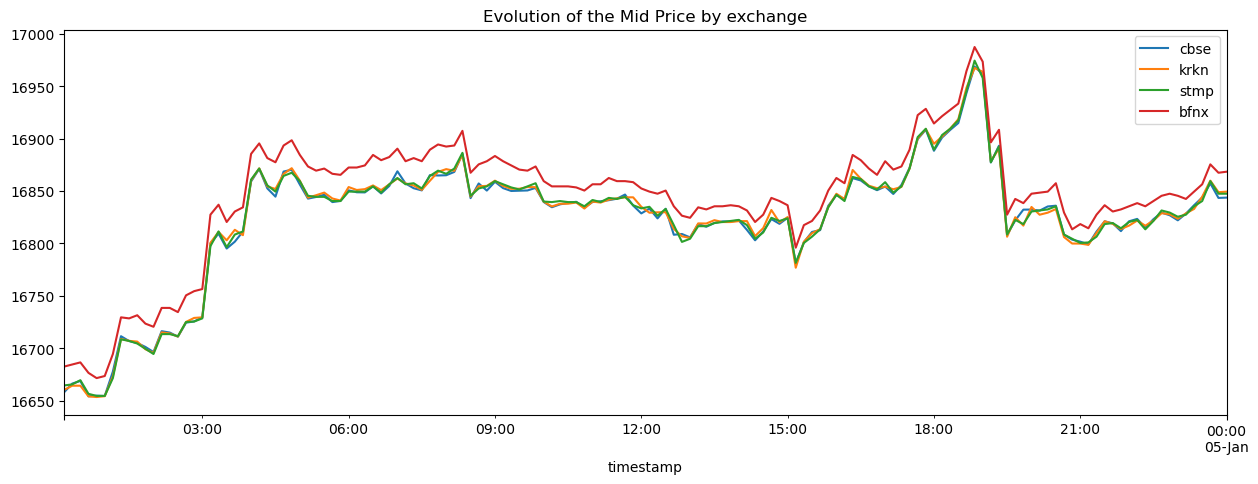

In [49]:
plt.figure(figsize = (15,5))
for exch in dfs:
    dfs[exch].mid.plot(label = exch)
plt.title('Evolution of the Mid Price by exchange')
plt.legend()
plt.show()

Display in a single graph the evolution of the spread by exchange.

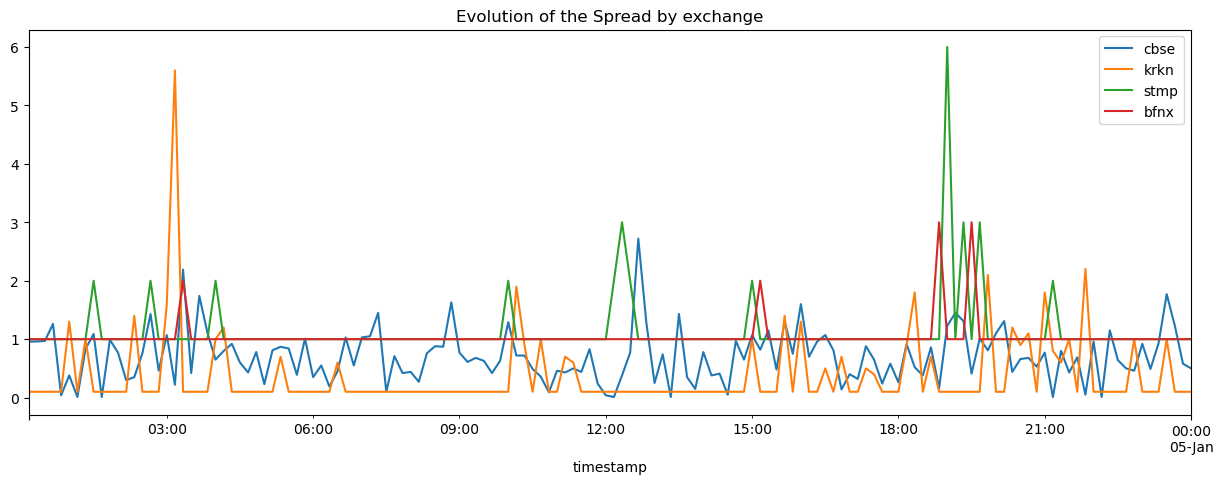

In [50]:
plt.figure(figsize = (15,5))
for exch in dfs:
    dfs[exch].spread.plot(label = exch)
plt.title('Evolution of the Spread by exchange')
plt.legend()
plt.show()

What do you notice? 

In [51]:
# The spread is significatively higher on Bitfinex (bfnx) and is never lower to 1 tick. 
# The mid-price is also significatively higher on Bitfinex (bnfx) even though those two indicators 
# are not necessarily correlated. 

For each exchange, display a representation of the Order Book snapshot on the 01/04/2023 at 7:00 pm. Use the right colors as seen in class, part 4. 

On each graph, draw a vertical line representing the mid price.  

Useful method: *pivot_table*

In [77]:
df_prova = dfs['cbse'].loc[dt.datetime(2023,1,4,19)]

In [79]:
tmp_prova = pd.DataFrame(df_prova.bids)
tmp_prova

,amount,price,type,cum_amount
0,0.027972,16960.97,bid,0.027972
1,0.080354,16960.96,bid,0.108325
2,0.227746,16960.95,bid,0.336071
3,0.400000,16960.94,bid,0.736071
4,0.030000,16960.78,bid,0.766071
...,...,...,...,...
995,0.012109,16418.05,bid,782.587893
996,0.002047,16417.32,bid,782.589940
997,0.000490,16417.13,bid,782.590430
998,0.358345,16417.06,bid,782.948776


In [78]:
tmp_prova.pivot(index = 'price', columns = 'type', values='cum_amount')

type,bid
price,
16416.34,783.039316
16417.06,782.948776
16417.13,782.590430
16417.32,782.589940
16418.05,782.587893
...,...
16960.78,0.766071
16960.94,0.736071
16960.95,0.336071


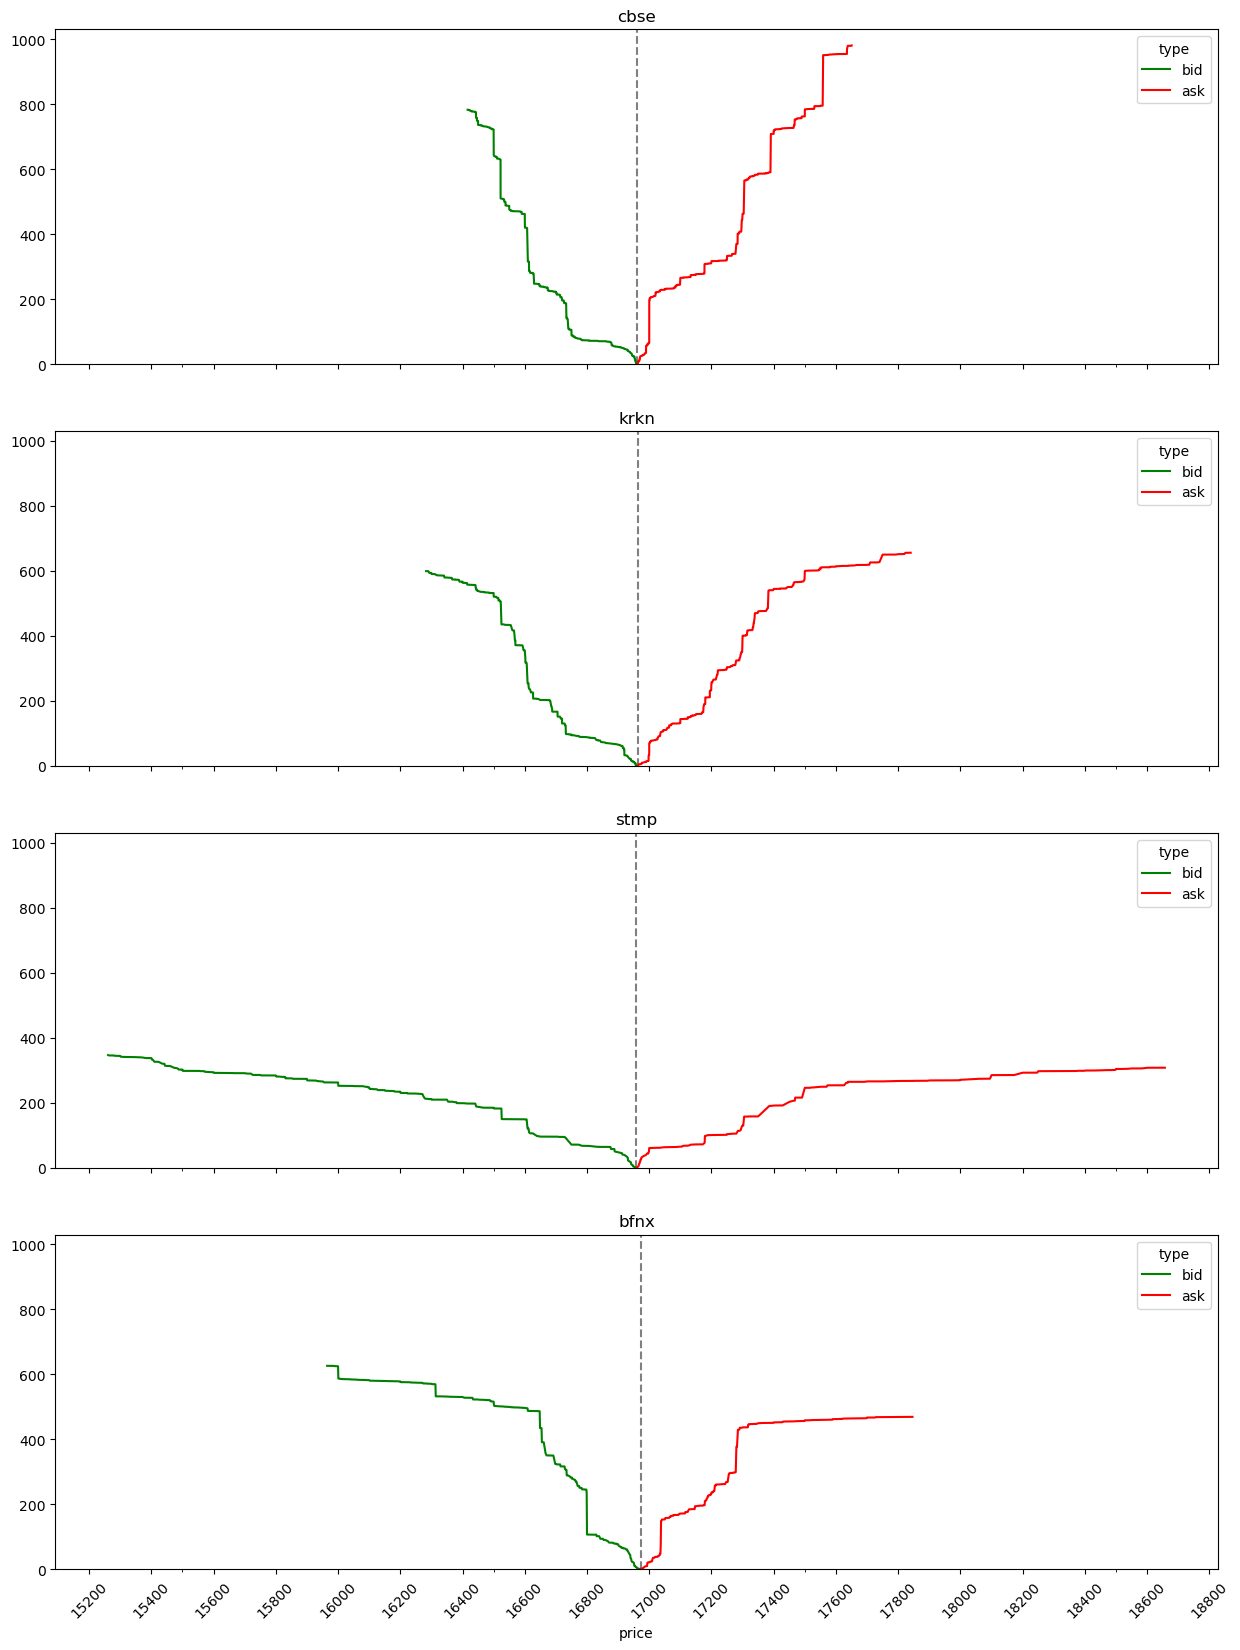

In [81]:
time = dt.datetime(2023,1,4,19)

fig, axs = plt.subplots(len(dfs), 1, figsize=(15, 5*len(dfs)), sharex=True, sharey=True)
for k in range(len(dfs)):
    ax = axs[k]
    
    df_exch = dfs[exchanges[k]].loc[time]
    
    # mid 
    ax.axvline(df_exch.mid, color = "grey", ls = "--")
    
    # bid
    tmp_bid = pd.DataFrame(df_exch.bids)
    tmp_bid.pivot(index = 'price', columns = 'type', values='cum_amount').plot(ax = ax, color = "green")
    
    # bid 
    tmp_bid = pd.DataFrame(df_exch.asks)
    tmp_bid.pivot(index = 'price', columns = 'type', values='cum_amount').plot(ax = ax, color = "red")
    ax.set_title(exchanges[k])
    
plt.ylim(bottom = 0)
plt.locator_params(axis = "x", nbins=20)
plt.xticks(rotation = 45)
plt.show()

Analyse the graphs above to answer the following questions:
- Which exchange offers the widest price range? # Bitstamp (STMP)
- Which exchange(s) are roughly balanced between bid and ask orders? # Bitstamp (stmp) and Kraken (krkn)
- Which exchange(s) have a positive volume imbalance? # Bitfinex (bfnx)
- Which exchange(s) have a negative volume imbalance? # Coinbase (cbse)
- On which exchange(s), can you buy more than 600 Bitcoins? # Coinbase (cbse) and Kraken (krkn)
- On which exchange(s), can you sell more than 600 Bitcoins? # Coinbase (cbse) and Bitfinex (bfnx)
- What do you observe around price \\$17,000 on Coinbase (cbse) or around price \\$17,020 on Bitfinex (bfnx)? What does this mean? # We observe a jump in the cumulative volume. This means that for these prices, the total ask size available is very high.
- What do you observe for prices higher than \\$17,400 on Bitfinex (bfnx)? # We observe a plateau, which means that we don't have many orders available for these prices. 

Display in two graphs the evolution of the total amount of asks orders and bid orders by exchange.

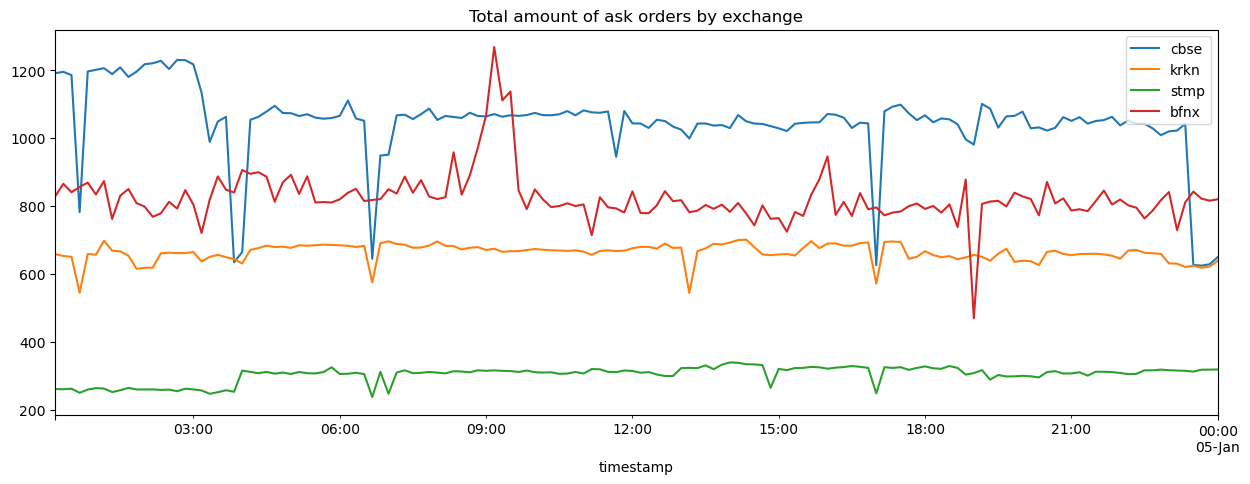

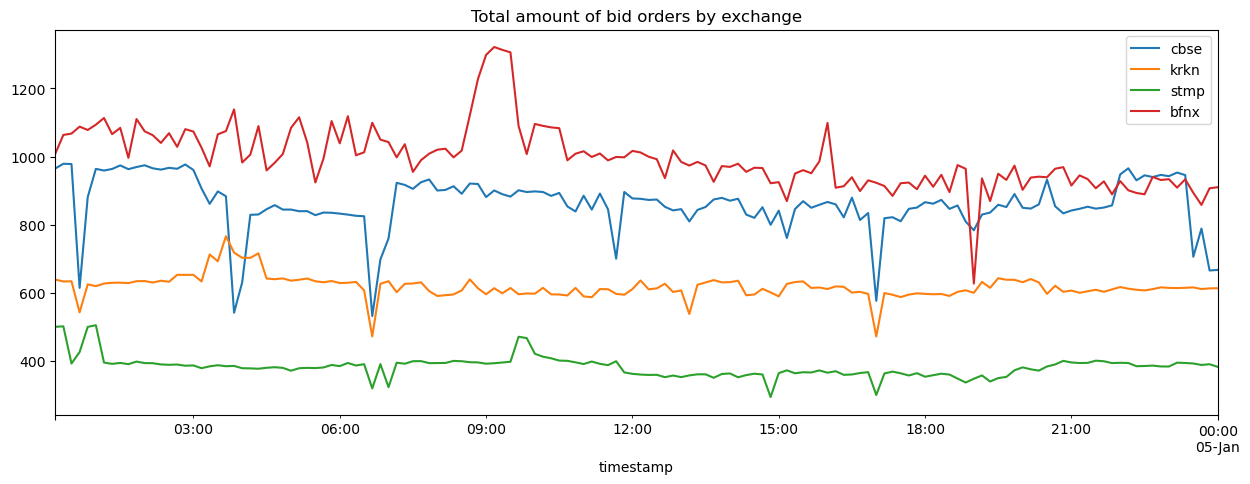

In [82]:
plt.figure(figsize = (15,5))
for exch in dfs:
    dfs[exch].total_ask_amount.plot(label = exch)
plt.title('Total amount of ask orders by exchange')
plt.legend()
plt.show()

plt.figure(figsize = (15,5))
for exch in dfs:
    dfs[exch].total_bid_amount.plot(label = exch)
plt.title('Total amount of bid orders by exchange')
plt.legend()
plt.show()

Using these graphs, answer the following questions:
- On which exchange(s), can you buy more than 600 Bitcoins most of the time? # Coinbase (cbse), Bitfinex (bfnx) and Kraken (krkn)
- On which exchange(s), can you sell more than 600 Bitcoins most of the time? # Coinbase (cbse), Bitfinex (bfnx) and Kraken (krkn)

Compare your answers with your previous ones and explain the differences. 

Display in a single graph the last bid and last ask available on each exchange. Keep the same color for the *last bid* curve and the *last ask* curve from the same exchange.

Also draw the mid price in grey and dotted line.

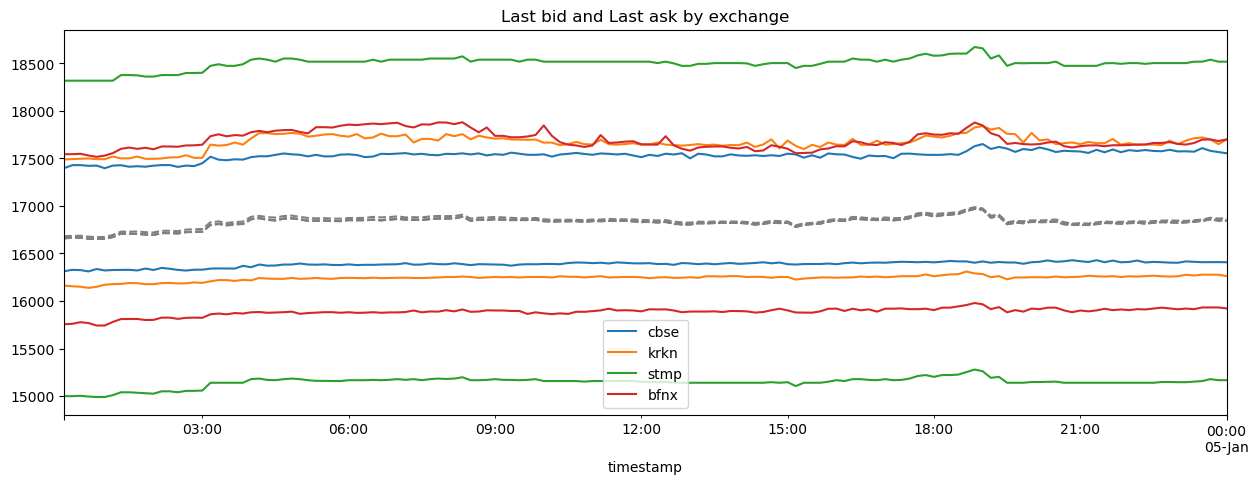

In [83]:
plt.figure(figsize = (15,5))
for k in range(len(dfs)):
    exch = exchanges[k]
    df_exch = dfs[exch]
    df_exch.last_ask.plot(label = exch, color = f'C{k}')
    df_exch.last_bid.plot(label = '', color = f'C{k}') 
    df_exch.mid.plot(color = "grey", ls = "--", label ="")
plt.title('Last bid and Last ask by exchange')
plt.legend()
plt.show()

Using the graph above, answer the following questions:
- Which exchange offers the widest price range? # Bitstamp (stmp)
- Which exchange offers the narrowest price range? # Coinbase (cbse)

Display in a single graph the spread between the last_bid and the mid-price, as well as the spread between the last ask and the mid-price. Keep the same color for the two values from the same exchange.

Also draw the line with ordinate 0 in grey and dotted line.

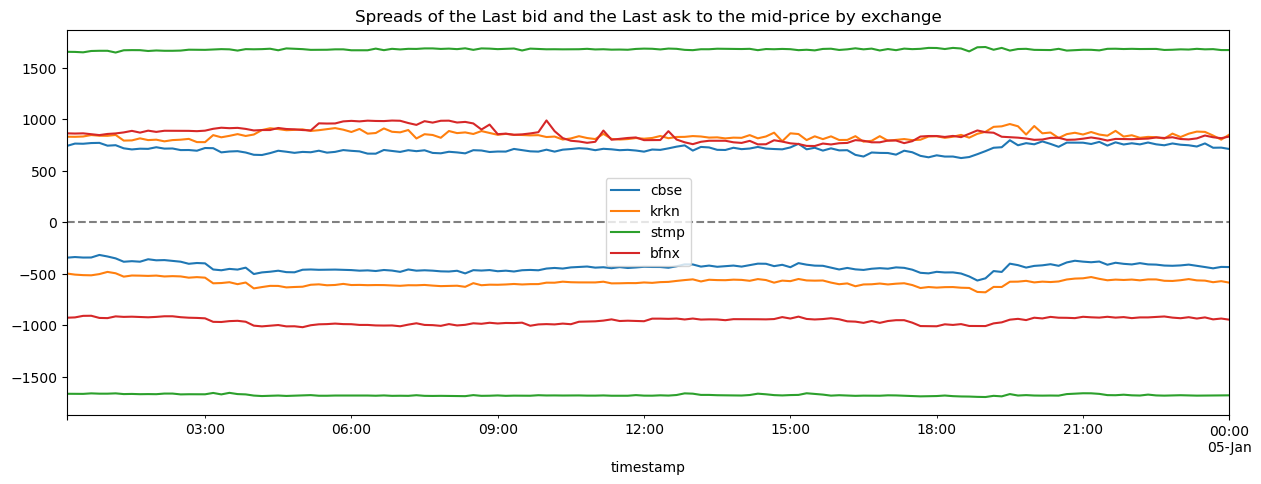

In [84]:
plt.figure(figsize = (15,5))
for k in range(len(dfs)):
    exch = exchanges[k]
    df_exch = dfs[exch]
    (df_exch.last_ask - df_exch.mid).plot(label = exch, color = f'C{k}')
    (df_exch.last_bid - df_exch.mid).plot(label = '', color = f'C{k}')
plt.gca().axhline(0, color = "grey", ls = "--", label ="")
plt.title('Spreads of the Last bid and the Last ask to the mid-price by exchange')
plt.legend()
plt.show()

Conclude on the balance between bid and ask last prices for each exchange.

In [85]:
# Bitfinex (bfnx) and Bitstamp (stmp) seem to be balanced.
# Coinbase (cbse) and Kraken (krkn) seem the have a negative imbalance.

### 2.2 Market impact computation

#### 2.2.1 Implementation

Implement the method *compute_market_impact* that returns a DataFrame containing the value of the market impact given a certain amount for each snapshot. 

The resulting DataFrame has the following characteristics:
- rows are labelled by snapshot timestamp 
- there are 2 columns
    - bid_market_impact: contains the value of the market impact of a selling market order with the given amount. 
    - ask_market_impact: contains the value of the market impact of a buying market order with the given amount. 
    
NB: 
- Feel free to implement intermediary methods to help you. 
- Try not to use any loop in this section. It is possible to do without it. 

In [86]:
def get_current_and_new_best_price_after_trade(orders, amount):
    index = (orders.cum_amount.values).searchsorted(amount)
    if index == len(orders):
        new_best = np.infty
    else:
        new_best = orders.price.loc[index]
    current_best = orders.price.loc[0]
    return current_best, new_best

def compute_one_market_impact(orders, amount):
    tmp = pd.DataFrame(orders)
    current, new = get_current_and_new_best_price_after_trade(tmp, amount)
    return (new - current)/current*100

def compute_market_impact(df, amount):
    res = pd.DataFrame(index = df.index, dtype = float)
    res[f'bid_market_impact'] = df.bids.apply(lambda x: compute_one_market_impact(x, amount))
    res[f'ask_market_impact'] = df.asks.apply(lambda x: compute_one_market_impact(x, amount))
    return res
    

#### 2.2.2 Market Impact analysis

Implement a method which returns in a Series the values of the market impact of an order at a given time for all exchanges. The input parameters are:
- the dictionary of order book DataFrame for each exchange
- the wanted order amount
- the snapshot time
- the side of the order (True if buying order, False if selling order)

In [87]:
def get_market_impact(dfs:dict, amount:float, time:dt.datetime, ask_side:bool):
    res = pd.Series(dtype=float)
    if ask_side:
        column = 'asks'
    else:
        column = 'bids'
    for k in range(len(dfs)):
        exchange = exchanges[k]
        df_exch = dfs[exchange]
        res.loc[exchange] = compute_one_market_impact(df_exch.loc[time, column], amount)
    return res

Answer to the following questions:
- On the 01/04/2023 at 14:00:
    - on which platform an order to buy 50 bitcoins will have the least impact? # Coinbase (cbse)
    - on which platform an order to sell 50 bitcoins will have the least impact? # Kraken (krkn)
    - on which platform an order to buy 250 bitcoins will have the least impact?  # Kraken (krkn)
    - on which platform an order to sell 250 bitcoins will have the least impact? # Bitfinex (bfnx)

In [88]:
time = dt.datetime(2023,1,4,14)

In [89]:
get_market_impact(dfs, 50, time, True).sort_values()

cbse    0.058137
krkn    0.071932
stmp    0.089164
bfnx    0.190069
dtype: float64

In [90]:
get_market_impact(dfs, 50, time, False).sort_values(ascending=False)

krkn   -0.013673
cbse   -0.058377
bfnx   -0.065340
stmp   -0.231839
dtype: float64

In [91]:
get_market_impact(dfs, 250, time, True).sort_values()

krkn    0.439916
cbse    0.453860
bfnx    0.593965
stmp    3.727040
dtype: float64

In [92]:
get_market_impact(dfs, 250, time, False).sort_values(ascending=False)

bfnx   -0.243540
krkn   -0.354907
cbse   -0.425525
stmp   -4.143384
dtype: float64

For each of following amounts, display a graph containing the evolution of the bid market impact and the evolution of the ask market impact of each exchange.  Keep the same color for the two values from the same exchange.

Also draw the line with ordinate 0 in grey and dotted line.

Amounts = 10, 100, 200, 500, 700, 800, and 1000

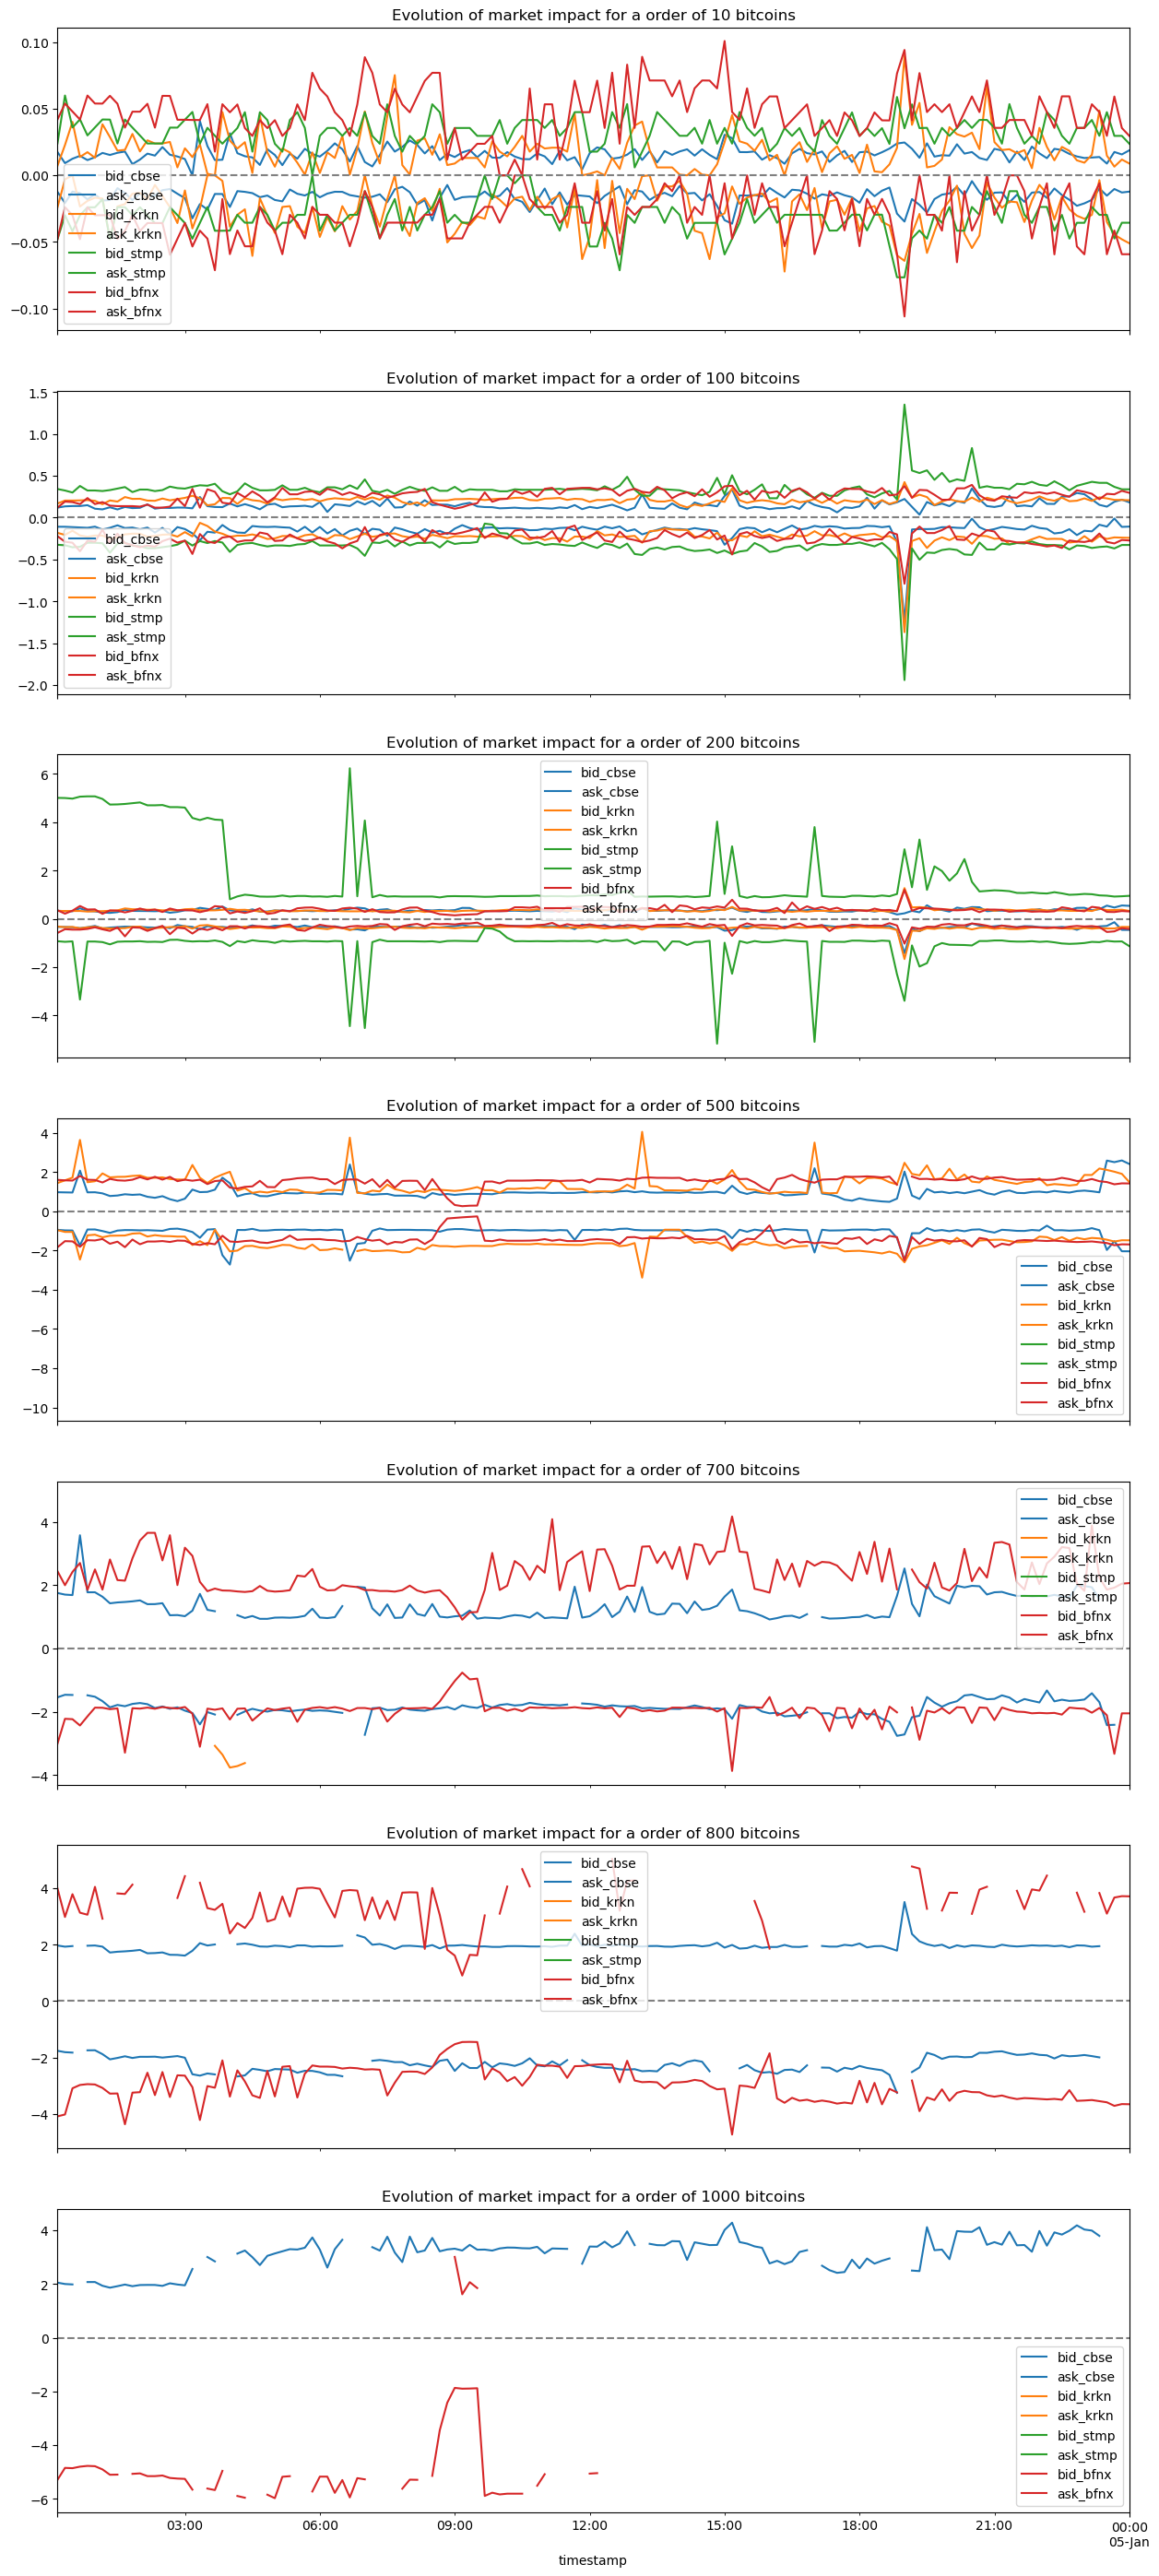

In [93]:
amounts = [10, 100, 200, 500, 700, 800, 1000]

fig, axs = plt.subplots(len(amounts), 1, figsize=(15, 5*len(amounts)), sharex=True)
for i in range(len(amounts)):
    amount = amounts[i]
    ax = axs[i]
    labels = []
    for k in range(len(dfs)):
        exchange = exchanges[k]
        df_exch = dfs[exchange]
        df_mi = compute_market_impact(df_exch, amount)
        labels.extend([f"bid_{exchange}", f"ask_{exchange}"])
        df_mi.dropna().plot(ax = ax, color = f'C{k}')
    ax.axhline(0, color = "grey", ls = "--")
    ax.legend(labels)
    ax.set_title(f'Evolution of market impact for a order of {amounts[i]} bitcoins')
plt.show()

Answer the following questions:
- What do you observe for an amount of 10 or 100 bitcoins? # The market impact is almost symmetrical, a little higher when it's a buy order (than a selling order).
- What can you say about the market impact for an order of 200 bitcoins on the exchange Bitstamp (stmp)? # It is very unstable and can double or triple at certain times of the day.
- What do you observe for amounts higher than 500 bitcoins on the exchange Bitstamp (stmp)? Make the connection with an analysis you made when you studied this exchange in part 2.1. # There is no ask or bid market impact (the market impact is infinite) because it's not possible to trade this amount of bitcoins on this exchange. Indeed, we saw that the maximum tradable amount on this exchange was between 300 and 400 bitcoins depending on the side of the order.
- Generally speaking, on which platform will a medium sell order (~500 bitcoins) have the least impact? # Coinbase (cbse)
- What are the only exchanges where you can buy large amounts (>800) of bitcoins? # Coinbase (cbse) and Bitfinex (bfnx)
- If I need to buy 1000 bitcoins, which platform will I go to? # Coinbase (cbse)
- If I need to sell 1000 bitcoins, which platform will I go to? What is the issue with this one? # Bitfinex (bfnx) but we can observe that half of the time, it is not possible to sell 1000 bitcoins. 


For each exchange, select the snapshot at time 19:00 UTC and display on a single graph the ask market impacts and the opposite of the bid market impact as a function of the amount from 1 to 500 bitcoins.

The bid market impact will be drawned in green and the ask market impact in red to respect the usual colors. 

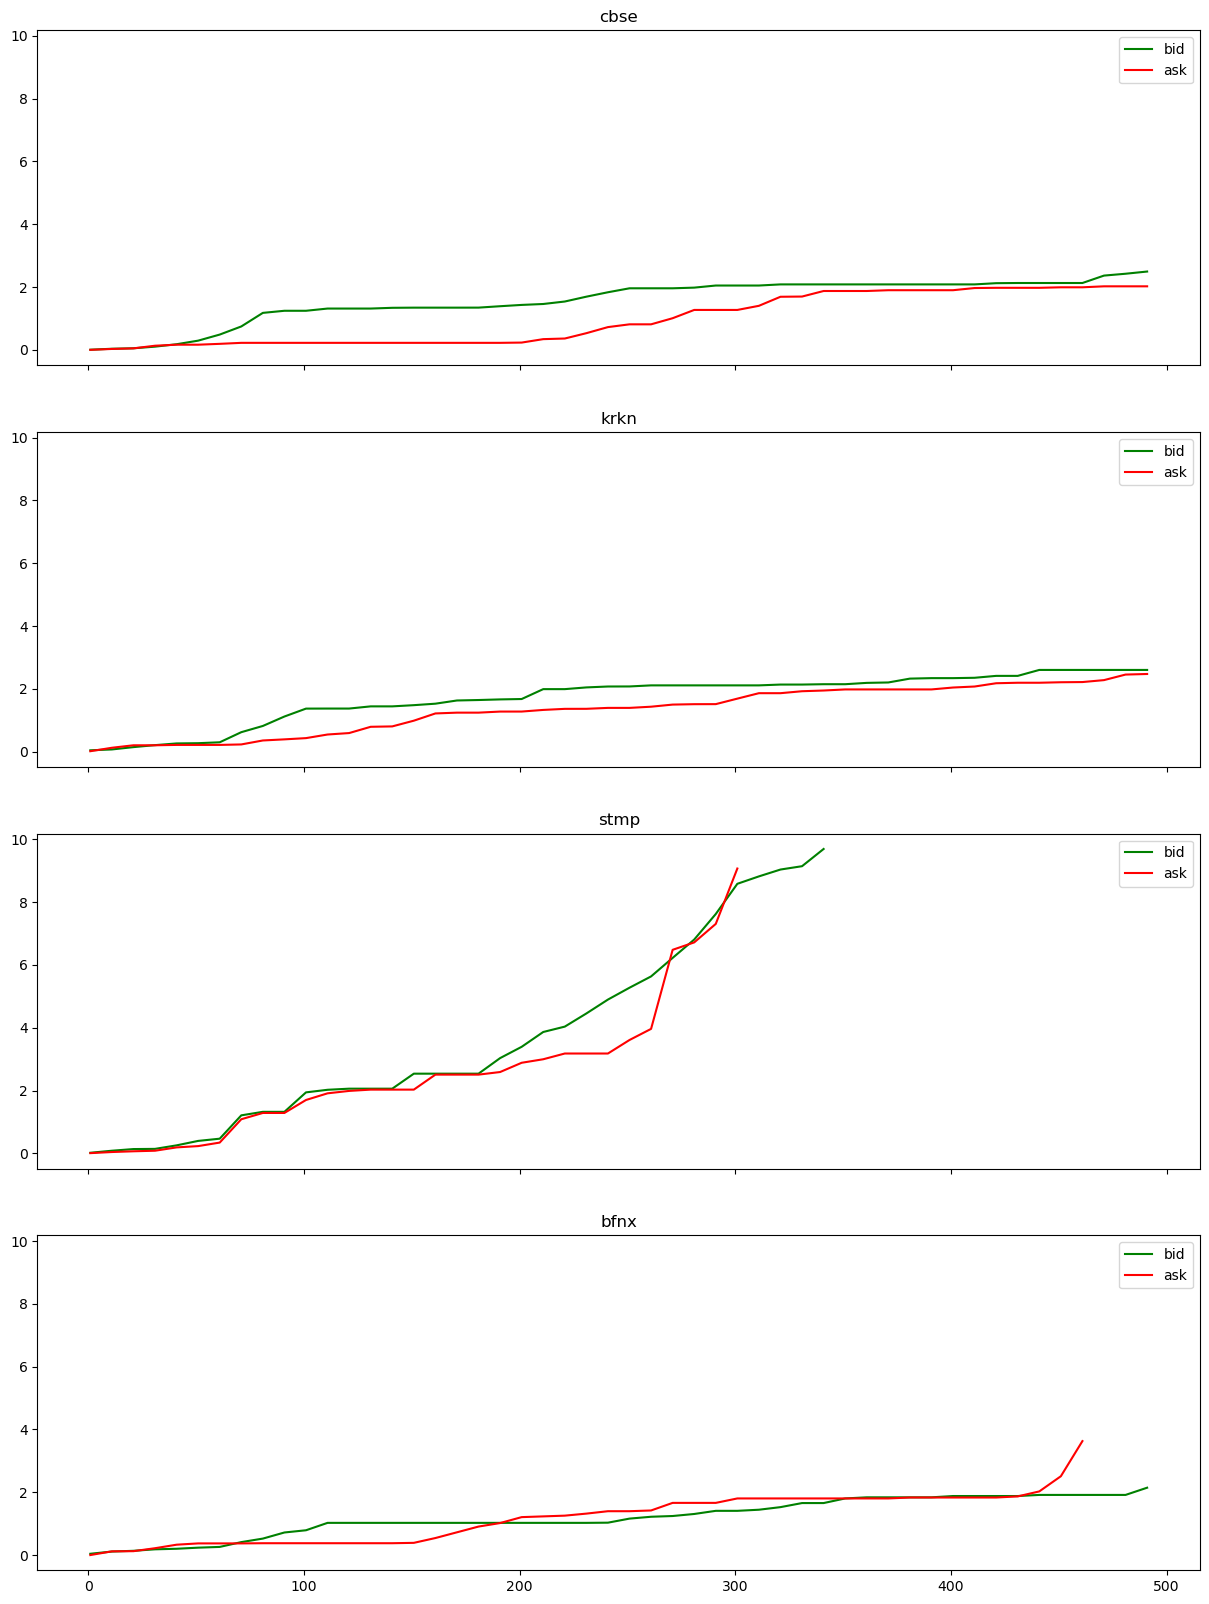

In [94]:
time = dt.datetime(2023,1,4,19)

amounts = np.arange(1, 500, 10)

fig, axs = plt.subplots(len(dfs), 1, figsize=(15, 5*len(dfs)), sharex=True, sharey=True)
for k in range(len(dfs)):
    exchange = exchanges[k]
    df_exch = dfs[exchange].loc[time]
    df_mi = pd.DataFrame(index = amounts, columns = ['bid', 'ask'])
    for amount in amounts:
        mi_ask = compute_one_market_impact(df_exch.asks, amount)
        df_mi.loc[amount,"ask"] = mi_ask
        mi_bid = compute_one_market_impact(df_exch.bids, amount)
        df_mi.loc[amount,"bid"] = -mi_bid
    ax = axs[k]
    df_mi.plot(ax = ax, color = ['green','red'])
    ax.set_title(exchange)
plt.show()
    
        

### 2.3 Price slippage and average trade price 

#### 2.3.1 Implementation

Implement the method *compute_average_trade_price* that computes at a specific time and given an order (amount, side), its average trade price. C.f. slides 18 "slippage".  
    
NB: 
- Feel free to implement intermediary methods to help you. 
- You can reuse some of the previously implemented methods.
- Try not to use any loop in this section. It is possible to do without it. 

In [95]:
def compute_average_trade_price(df:pd.DataFrame, amount:float, time:dt.datetime, ask_side:bool):
    if ask_side:
        orders = df.asks
    else:
        orders = df.bids
    tmp = pd.DataFrame(orders.loc[time])
    current, new = get_current_and_new_best_price_after_trade(tmp, amount)
    if current == new:
        return current
    elif new == np.inf:
        return np.inf
    else:
        if new < current:
            extract = tmp[tmp.price.between(new, current, inclusive='both')]
        else:
            extract = tmp[tmp.price.between(current, new, inclusive='both')]
        mask = (extract.price == new)
        index = mask[mask].index[0]
        extract.loc[index, 'amount'] = amount - extract.loc[index-1, 'cum_amount']
        
        avg_price = (extract.price * extract.amount).sum()/extract.amount.sum()
        return avg_price

Implement a method which returns in a Series the average price of an order at a given time for all exchanges. The input parameters are:
- the dictionary of order book DataFrame for each exchange
- the wanted order amount
- the snapshot time
- the side of the order (True if buying order, False if selling order)

In [67]:
def get_average_trade_price_for_all_exchanges(dfs:dict, amount:float, time:dt.datetime, ask_side:bool):
    res = pd.Series(dtype=float)
    for k in range(len(dfs)):
        exchange = exchanges[k]
        df_exch = dfs[exchange]
        res.loc[exchange] = compute_average_trade_price(df_exch, amount, time, ask_side)
    return res

Create a new DataFrame containing the average price of a buy order by trade amount (row label) and by exchange (column label). 

Take the snapshots as of 01/04/2023 at 19:00 UTC.

The amounts to compute are given below: 

In [68]:
time = dt.datetime(2023,1,4,19)

amounts = np.arange(0, 500, 10)

In [69]:
df_avg_price_ask = pd.DataFrame(index = amounts, columns = exchanges)
for k in range(len(dfs)):
    exchange = exchanges[k]
    df_exch = dfs[exchange]
    for amount in amounts:
        avg_price = compute_average_trade_price(df_exch, amount, time, True)
        df_avg_price_ask.loc[amount,exchange] = avg_price

Plot the information in this DataFrame. What do you conclude?

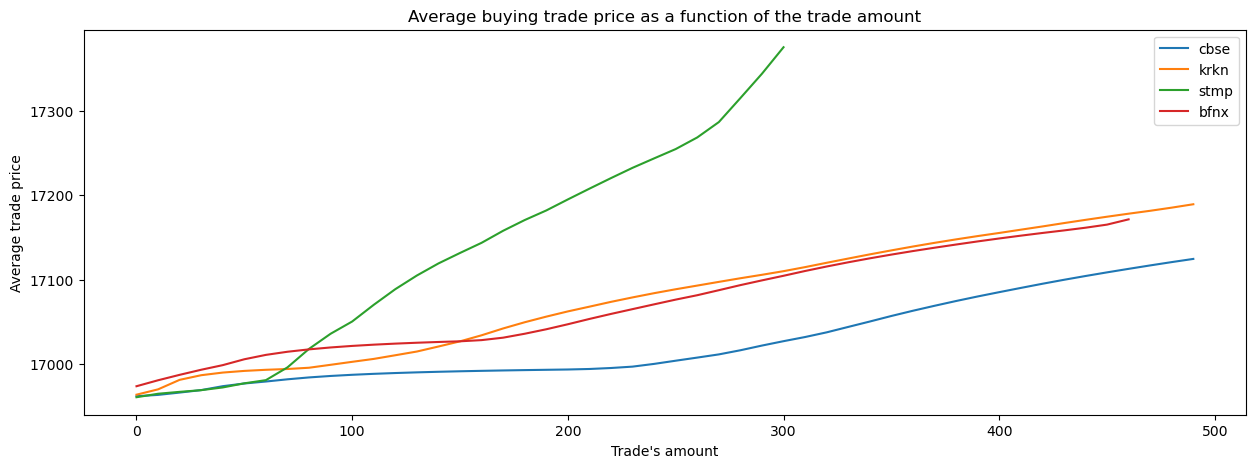

In [70]:
df_avg_price_ask.plot(figsize = (15,5))
plt.title("Average buying trade price as a function of the trade amount")
plt.xlabel("Trade's amount")
plt.ylabel("Average trade price")
plt.show()    

In [71]:
# At 19:00, no matter how much we want to buy, Coinbase is always the most profitable platform.

Do the same of the sell orders. What is the conclusion here?

In [72]:
df_avg_price_bid = pd.DataFrame(index = amounts, columns = exchanges)
for k in range(len(dfs)):
    exchange = exchanges[k]
    df_exch = dfs[exchange]
    for amount in amounts:
        avg_price = compute_average_trade_price(df_exch, amount, time, False)
        df_avg_price_bid.loc[amount,exchange] = avg_price

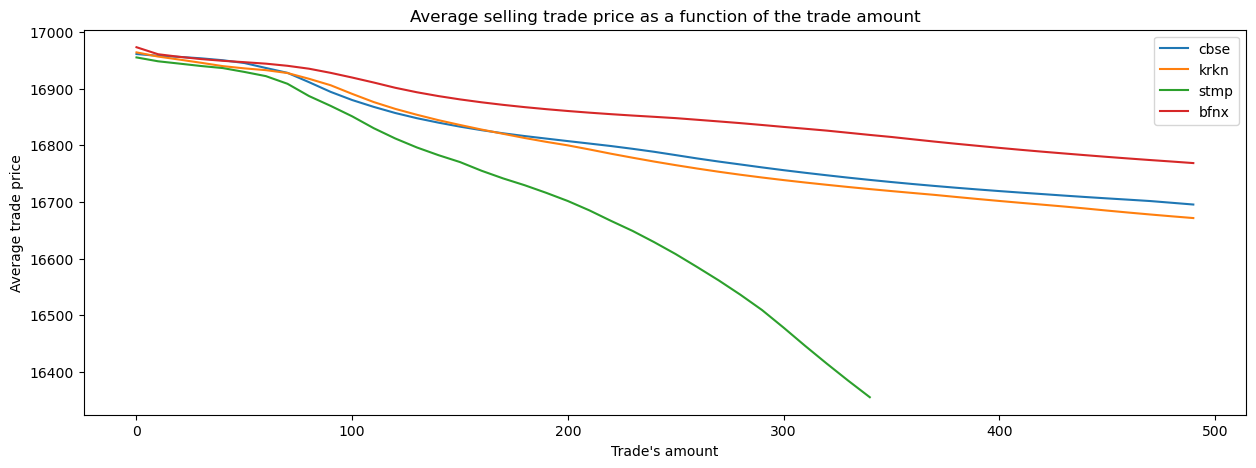

In [73]:
df_avg_price_bid.plot(figsize = (15,5))
plt.title("Average selling trade price as a function of the trade amount")
plt.xlabel("Trade's amount")
plt.ylabel("Average trade price")
plt.show()    

In [74]:
# At 19:00, if we want to sell more than 70 bitcoins, Bitfinex seems to be most profitable platform.

Bonus: compute the same information at 14:00 and compare the conclusions

In [75]:
# At 14:00, Coinbase (cbse) and Kraken (krkn) gives the same average purchase price regardless of the amount.
# Bitfinex gives by far the best average selling prices regardless of the amount.